In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import RegressorMixin, TransformerMixin
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet, ElasticNetCV

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit


In [2]:
# Import custom classes
from supervised_model_pipeline import EdaToolbox, RegressorMultiModelEvaluator

## Inspect the data

In [3]:
# Load the training data
cincinnati_file_path = '../../Data/Clean/combined/Cincinnati_combined.csv'
train_full_df = pd.read_csv(cincinnati_file_path)
train_full_df.head()

,DATE,MeanSalePrice,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,155566.0,1939.0,278000302.0,154159.712821,157939.052238,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,1047.0,-1.8,1418.62244,93.921524,43.323481,"CINCINNATI, OH"
1,2008-05-31,158474.0,2190.0,315975507.0,154896.973753,157678.462221,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,1045.6,-1.8,1418.62244,93.921524,43.323481,"CINCINNATI, OH"
2,2008-06-30,164199.0,2286.0,352017758.0,155768.803669,157332.615865,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,1041.2,-1.3,1418.62244,93.921524,43.323481,"CINCINNATI, OH"
3,2008-07-31,167422.0,2224.0,374100404.0,156376.821297,157143.826684,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,1045.1,-0.6,1418.62244,93.921524,43.323481,"CINCINNATI, OH"
4,2008-08-31,166249.0,2193.0,371690060.0,155577.849578,156653.274461,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,1043.8,-0.6,1418.62244,93.921524,43.323481,"CINCINNATI, OH"


In [4]:
# Remove columns that are too predictive
cols_to_remove = ['HomeValueIndexSmSa', 'HomeValueIndex']
train_full_df = train_full_df.drop(cols_to_remove, axis=1)

## Create an EdaToolbox object

In [5]:
# Initialize the EdaToolbox
target_col = 'MeanSalePrice'
eda = EdaToolbox(train_full_df, target_column=target_col)

In [6]:
col_info_df = eda.gather_initial_column_info()
col_info_df.head()

,data_type,max_value_count_pct,most_frequent_value,unique_values,missing_values,missing_values_pct,top_10_values
CityName,object,1.000000,"CINCINNATI, OH",1,0,0.0,"Index(['CINCINNATI, OH'], dtype='object', name..."
DATE,object,0.005128,2008-04-30,195,0,0.0,"Index(['2008-04-30', '2012-05-31', '2009-03-31..."
People25PlusThousands_2019,float64,1.000000,1418.62244,1,0,0.0,"Index([1418.62244], dtype='float64', name='Peo..."
PctHighSchoolDiploma_2019,float64,1.000000,93.921524,1,0,0.0,"Index([93.921524], dtype='float64', name='PctH..."
PctBachelorsDegree_2019,float64,1.000000,43.323481,1,0,0.0,"Index([43.323481], dtype='float64', name='PctB..."


In [7]:
eda.prune_infreq_categorical = 0.9
eda.prune_infreq_numerical = 0.95
eda.prune_pct_missing = 0.8

## First check the distribution of the target column and select an appropriate target column transformer

In [8]:
# It is not normally distributed. It has a long tail to the right. Need to try different target transformations
target_transformation_dict: dict[str, TransformerMixin] = {
    'StandardScaler': StandardScaler(),
    'PowerTransformer': PowerTransformer(standardize=False),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal', n_quantiles=500, random_state=42),
}

In [9]:
# Create a dict of models for preliminary testing of target transformations
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=1.0, random_state=42),
    'ElasticNet Regression': ElasticNet(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV(np.logspace(-6, 6, 25)),
    'HistGradientBoost': HistGradientBoostingRegressor(max_iter=200, random_state=42)
}


In [10]:
kf_cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [11]:
# Use basic ordinal feature transformer
eda.feature_transformer = eda.get_basic_ordinal_feature_transformer()

In [12]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features
model_pred_cv_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict, kf_cv)
model_pred_cv_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of 

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.161782,0.160410,1.000307,0.699692,0.225997,0.258608,0.160410,0.100555
PowerTransformer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
QuantileTransformer,0.359732,0.342376,1.065387,0.739473,0.335289,0.336325,0.358833,0.342084


Note for Cincinatti dataset
* HistGradientBoost shows best performance
* Lasso Regression shows poor performance
* Zero Errors in PowerTransformer: The zeros reported with the PowerTransformer across all models = suspicious

In [13]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features without CV
model_pred_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict)
model_pred_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of 

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.160693,0.165886,0.976367,0.673424,0.158338,0.159068,0.165886,0.105572
PowerTransformer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
QuantileTransformer,0.298456,0.212655,0.955622,0.619234,0.177962,0.186321,0.290236,0.190636


Note for Cincinnati dataset
* HistGradientBoost and LassoCV are most consistent top performers 

In [14]:
# Use basic OHE feature transformer
eda.feature_transformer = eda.get_basic_ohe_feature_transformer()

In [15]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features
model_pred_cv_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict, kf_cv)
model_pred_cv_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of 

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.252315,0.259291,1.000307,0.771062,0.410569,0.459923,0.257039,0.169264
PowerTransformer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
QuantileTransformer,0.502262,0.476785,1.096834,0.832068,0.564346,0.573775,0.481116,0.391060


Note for Cincinnati dataset
* HistGradientBoost with the best result with lowest RMSE

In [16]:
# Evaluate RMSE for various regression models and target transformations with all ordinally encoded categorical features without CV
model_pred_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict)
model_pred_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of 

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.301982,0.326072,0.976367,0.743423,0.323048,0.323918,0.319118,0.214808
PowerTransformer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
QuantileTransformer,0.595847,0.511914,1.000282,0.717471,0.473120,0.484253,0.533566,0.231617


Note:
* HistGradientBoost still has the best result, made even better than the last with lowest RMSE
* Linear Regression, Ridge, Lasso, ElasticNet have higher RMSEs across transformations

## Set the target and feature column tranformers

In [17]:
eda.target_transformer = StandardScaler()
eda.feature_transformer = eda.get_basic_ordinal_feature_transformer()

## Prepare the data for feature selection

In [18]:
# Gather initial column information sorted by data type and max value count to check for columns with high cardinality that can be pruned
col_info_df = eda.gather_initial_column_info()
col_info_df.head()

,data_type,max_value_count_pct,most_frequent_value,unique_values,missing_values,missing_values_pct,top_10_values
CityName,object,1.000000,"CINCINNATI, OH",1,0,0.0,"Index(['CINCINNATI, OH'], dtype='object', name..."
DATE,object,0.005128,2008-04-30,195,0,0.0,"Index(['2008-04-30', '2012-05-31', '2009-03-31..."
People25PlusThousands_2019,float64,1.000000,1418.62244,1,0,0.0,"Index([1418.62244], dtype='float64', name='Peo..."
PctHighSchoolDiploma_2019,float64,1.000000,93.921524,1,0,0.0,"Index([93.921524], dtype='float64', name='PctH..."
PctBachelorsDegree_2019,float64,1.000000,43.323481,1,0,0.0,"Index([43.323481], dtype='float64', name='PctB..."


In [19]:
# Set pruning thresholds on the eda object according to column data type and cardinality for this dataset
eda.prune_infreq_categorical = 0.9
eda.prune_infreq_numerical = 0.95
eda.prune_pct_missing = 0.8

## Feature analysis

In [20]:
# Frist check what the correlation and coefficient numbers look like
fa_df = eda.get_regression_feature_analysis_df()
fa_df.head()

Best RidgeCV alpha: 1.0 (R^2 score:  0.98)


/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,correlation_abs,coefficient_abs,pval,vif,PCA1_abs,PCA2_abs,total
ordinal_date__DATE,0.944879,0.664163,0.615031,18.926087,0.143562,0.229945,1.982548
numerical__TotalTransactionValue,0.838511,0.373379,0.822219,31.902751,0.174339,0.342890,1.729118
numerical__SalesCount,0.458094,0.223971,0.761940,6.669395,0.079194,0.450194,1.211454
numerical__NUM_JOBS,0.809906,0.031419,0.981579,5.902741,0.117387,0.130752,1.089464
numerical__NewConstructMeanSalePrice,0.456073,0.075504,0.923183,7.708817,0.293629,0.198029,1.023236


/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


ValueError: num must be an integer with 1 <= num <= 12, not 13

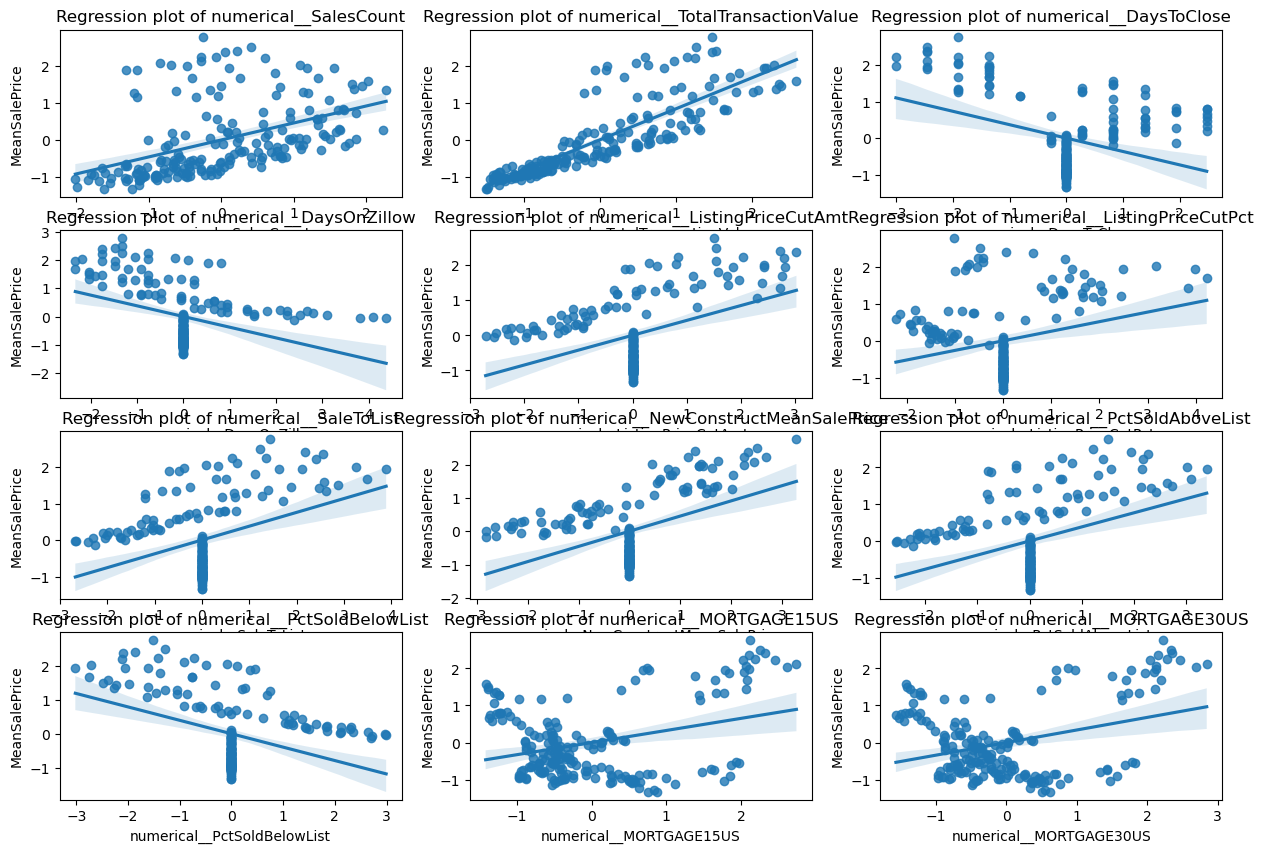

In [25]:
# Plot out the highly correlated features
eda.plot_regression_feature_correlations(corr_min=0.2)

/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


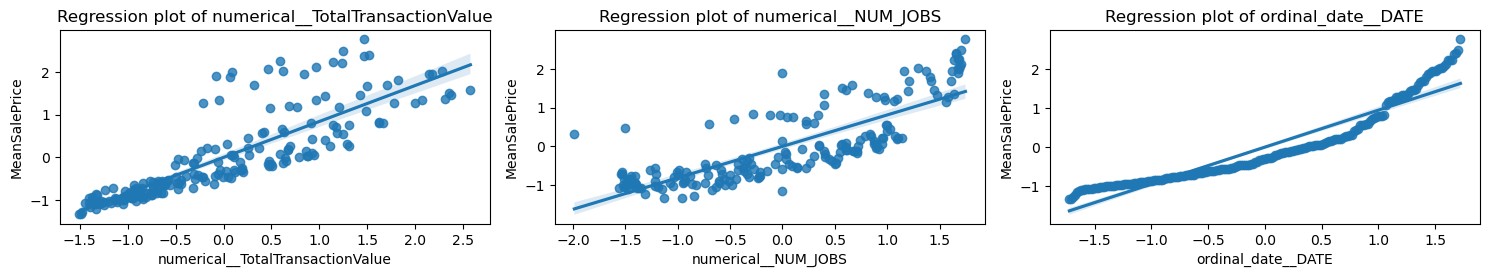

In [26]:
# Plot out the highly correlated features
eda.plot_regression_feature_correlations(corr_min=0.5)

## Perform unsupervised feature selection

Optimal number of features: 6


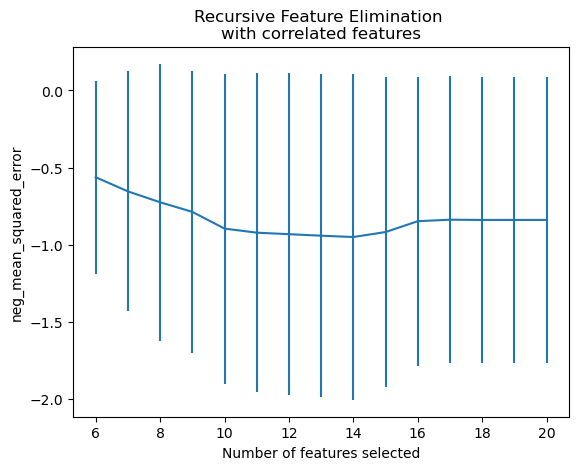

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,selected,ranking,feature_name
0,-2.389436,2.936076,-3.063523,-0.063120,-0.105455,-0.873783,-7.841299,True,1,SalesCount
1,-3.233141,3.419827,-4.911600,-0.096041,-0.141163,-1.909628,-9.107273,True,1,TotalTransactionValue
2,-3.260677,3.450283,-4.841196,-0.084145,-0.144305,-2.003089,-9.230650,False,12,MarketTempIdx
3,-1.763490,2.626307,-0.100743,-0.087016,-0.078884,-6.869131,-1.681676,False,6,DaysToClose
4,-2.843567,4.777849,-0.159827,-0.050098,-0.086616,-12.328692,-1.592602,False,11,DaysOnZillow


In [27]:
# Try recursive feature elimination to find the optimal number of features for a linear regression model
regressor = LinearRegression()
rfecv_results_df = eda.perform_unsupervised_regression_rfe_feature_selection(regressor)
rfecv_results_df.head()

In [28]:
rfe_lr_selected_features = eda.get_rfe_selected_features(rfecv_results_df)
print(f"RFE LR Selected Features: {rfe_lr_selected_features}")

RFE LR Selected Features: ['SalesCount' 'TotalTransactionValue' 'SaleToList' 'MORTGAGE15US'
 'MORTGAGE30US' 'DATE']


Optimal number of features: 3


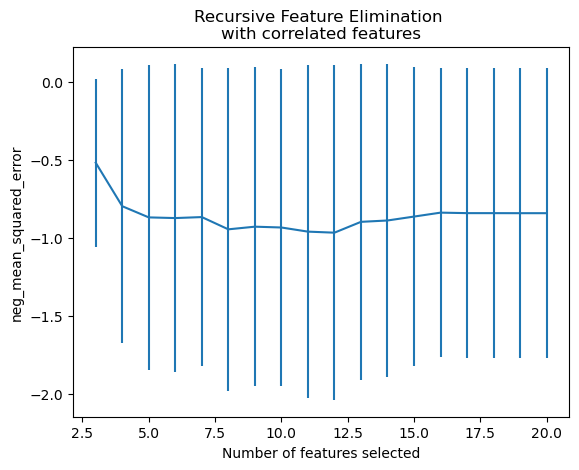

In [30]:
# Try recursive feature elimination to find the optimal number of features for a RidgeCV model
regressor = RidgeCV(alphas=np.logspace(-6, 6, num=6))
rfecv_results_df = eda.perform_unsupervised_regression_rfe_feature_selection(regressor)


In [31]:
rfe_ridge_selected_features = eda.get_rfe_selected_features(rfecv_results_df)
print(f"RFE Ridge Selected features: {rfe_ridge_selected_features}")

RFE Ridge Selected features: ['SalesCount' 'SaleToList' 'DATE']


In [32]:
# Try using forward SFS (SequentialFeatureSelector) to select the top 10 features
sfs_ridge_selected_features = eda.perform_unsupervised_regression_sfs_feature_selection(n_features=10)
print(f"SFS Ridge Selected Features: {sfs_ridge_selected_features}")


RidgeCV best alpha 1.0
Selected 10 features by forward sequential featureselection in 1.169 seconds
SFS Ridge Selected Features: ['SalesCount', 'TotalTransactionValue', 'MarketTempIdx', 'NewConstructSalesCount', 'PctListingsPriceCut', 'PctSoldBelowList', 'MORTGAGE15US', 'GROWTH_PCT', 'DATE', 'CityName']


In [33]:
# # Remove colinear features from the list of selected features
# # rfe_ridge_selected_features = [rfe_ridge_selected_features]
# rfe_ridge_selected_features = list(rfe_ridge_selected_features).remove('PctListingsPriceCut')
# rfe_ridge_selected_features

In [34]:
# Update EDA object with selected features from RFE
eda.selected_feature_list = rfe_ridge_selected_features

# Now get the list of selected ordinal columns
final_ordinal_cols = eda.get_final_ordinal_col_names(rfe_lr_selected_features)
len(final_ordinal_cols), final_ordinal_cols

(1, ['DATE'])

## Perform final EDA with selected features and ordinal columns

In [35]:
# Reset transformer properties to use the selected columns and ordinal columns
eda.ordinal_encoding_col_dict = {}
for col_name in final_ordinal_cols:
    eda.add_ordinal_encoding_column(col_name, None)

eda.feature_transformer = eda.create_feature_transformer()
eda.feature_transformer

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(memory='named_steps',
                                          steps=[('pruner',
                                                  SimplePruner(infreq=0.95,
                                                               pct_miss=0.8)),
                                                 ('selector',
                                                  SelectedFeaturesTransformer(selected_feature_list=array(['SalesCount', 'SaleToList', 'DATE'], dtype=object))),
                                                 ('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 Index(['SalesCount', 'TotalTransactionValu...
                                                                              '2010-01-31',
                                                                              '2011-12-31',
                                                                              '2008-11-30',
                                                                              '2009-11-30',
                                                                              '2011-11-30',
                                                                              '2012-03-31',
                                                                              '2010-04-30',
                                                                              '2013-02-28',
                                                                              '2010-03-31',
                                                                              '2014-03-31',
                                                                              '2014-02-28',
                                                                              '2009-10-31',
                                                                              '2013-03-31',
                                                                              '2011-05-31',
                                                                              '2009-06-30',
                                                                              '2011-02-28',
                                                                              '2014-01-31',
                                                                              '2012-12-31', ...]],
                                                                 encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('scaler', StandardScaler())]),
                                 ['DATE'])])

In [36]:
# Check feature analysis to ensure we have no multicollinearity (ie. no infinite vifs)
feature_analysis_df = eda.get_regression_feature_analysis_df()
feature_analysis_df.head()

Best RidgeCV alpha: 1e-06 (R^2 score:  0.96)


,correlation_abs,coefficient_abs,pval,vif,PCA1_abs,PCA2_abs,total
ordinal_date__DATE,0.944879,1.036198,0.006431,1.620335,0.659151,0.252947,2.893175
numerical__SaleToList,0.378841,0.211759,0.485631,1.052476,0.364579,0.931148,1.886327
numerical__SalesCount,0.458094,0.219088,0.560459,1.616800,0.657725,0.262643,1.597550


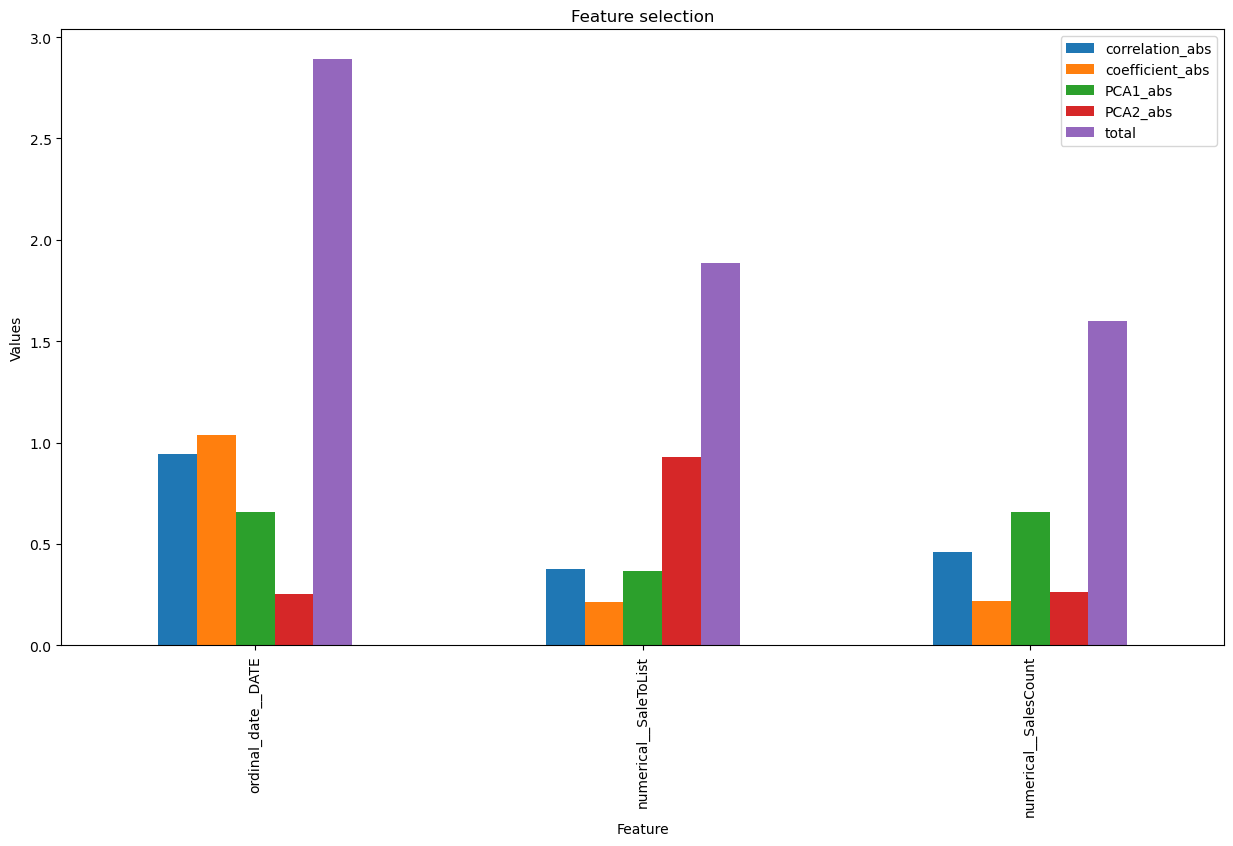

In [37]:
eda.plot_important_features(feature_analysis_df)

# Now do model analysis for multiple regression models

In [38]:
# Reload the data just to be safe
train_full_df = pd.read_csv(cincinnati_file_path)

# Create an instance of RegressorMultiModelEvaluator and set various properties
reg = RegressorMultiModelEvaluator(train_full_df, target_column=target_col)
reg.set_column_transformer_properties(selected_feature_list=eda.selected_feature_list, ordinal_feature_list=final_ordinal_cols)
reg.set_target_column_transformer(eda.target_transformer)

In [39]:
# Create a dict of models to test
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV(alphas=np.logspace(-6, 6, num=7)),
    'HistGradientBoost': HistGradientBoostingRegressor(max_iter=200, random_state=42)
}

In [40]:
# Evaluate the models
eval_df = reg.evaluate_models(model_dict)
eval_df

Number original X cols: 25
Number scaled X cols: 3


,train_r2,mse,r2,r2_adj,lr_cv_mean,lr_cv_std,time,y_pred
model_name,,,,,,,,
HistGradientBoost,0.992633,0.005387,0.994345,0.993861,0.913045,0.072491,0.360472,"[0.22102440973297105, -0.8397778885759789, 0.5..."
Ridge Regression,0.961718,0.050691,0.946787,0.942226,0.913045,0.072491,0.007495,"[0.2565546269837643, -0.9123634594970697, 0.72..."
ElasticNetCV,0.961792,0.051241,0.946210,0.941599,0.913045,0.072491,0.043705,"[0.2582472000609477, -0.9176969341601655, 0.72..."
LassoCV,0.961799,0.051380,0.946063,0.941440,0.913045,0.072491,0.041721,"[0.2581726639051252, -0.9188329315043123, 0.72..."
RidgeCV,0.961805,0.051597,0.945836,0.941193,0.913045,0.072491,0.007412,"[0.2560528581861501, -0.9199475405807315, 0.72..."
Linear Regression,0.961805,0.051597,0.945836,0.941193,0.913045,0.072491,0.008008,"[0.25605289638176665, -0.919947620969304, 0.72..."


* RidgeCV a little better with balance of high r2 and r2_adj, low mse, consistent cross-validation results

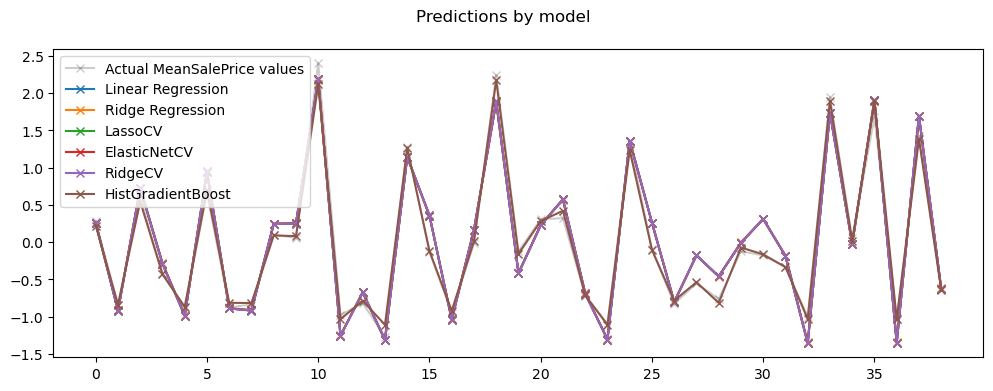

In [41]:
reg.plot_model_evaluations()

* Looks overfit to me

In [41]:
# Get the best model
reg.best_model_name

'Ridge Regression'

## Now use the best model to predict on the test data

In [42]:
# Load test data from a different city
combined_file_path = '../../Data/Clean/combined/all_cities_combined.csv'
test_full_df = pd.read_csv(combined_file_path)
test_full_df.head()

,DATE,MeanSalePrice,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,200954.0,6463.0,1.235943e+09,185168.707578,189442.061550,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,2454.9,-3.5,4414.04779,89.810682,41.859123,"ATLANTA, GA"
1,2008-05-31,203419.0,6729.0,1.317605e+09,185331.245765,188426.220342,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,2450.9,-6.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"
2,2008-06-30,205746.0,7047.0,1.388670e+09,185185.095114,187437.288971,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,2442.4,-6.1,4414.04779,89.810682,41.859123,"ATLANTA, GA"
3,2008-07-31,205553.0,7086.0,1.429205e+09,184692.089305,186253.861325,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,2434.6,-6.8,4414.04779,89.810682,41.859123,"ATLANTA, GA"
4,2008-08-31,202855.0,6383.0,1.388101e+09,183376.364934,184882.815462,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,2429.3,-7.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"


In [43]:
# Drop target column
combined_file_df = test_full_df[target_col]
test_full_df = test_full_df.drop(columns=[target_col]) 
test_full_df.head()

KeyError: "['MeanSalePrice'] not found in axis"

In [52]:
# Make predictions with HistGradientBoost
#reg.best_model = model_dict['Linear Regression']
lr_predictions = reg.predict(test_full_df)
lr_predictions

array([196606.75008567, 199628.83459339, 201684.87637794, 200652.66189617,
       198613.30124795, 191729.23822738, 186125.99765161, 178196.75506636,
       174843.94760544, 162387.25676913, 157376.17426905, 151286.45251209,
       154622.31205013, 161655.94872807, 175672.67480683, 181653.12194711,
       184316.01967694, 179911.72165015, 177349.01277639, 176507.67475473,
       173205.05438723, 170792.17534001, 166887.89797862, 165365.84205734,
       172394.7619298 , 179050.96870049, 182533.90984736, 183421.51819959,
       180779.08279687, 174021.4286768 , 160208.97338809, 155303.5431149 ,
       156680.42756807, 160929.87133251, 155989.5661641 , 153274.0432015 ,
       151944.39977619, 158076.85378968, 169213.1825001 , 169999.75961204,
       163865.77279975, 149984.0913178 , 149339.59270538, 148063.75151315,
       147432.32723577, 146805.18017669, 145563.55956816, 146182.27068307,
       148699.49313454, 150633.03055772, 158782.51424193, 167657.30942395,
       166124.09416407, 1

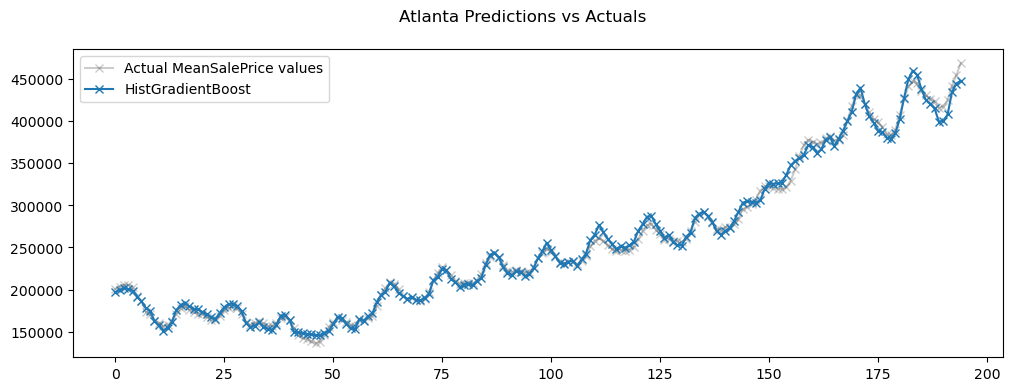

In [53]:
# Plot Actual vs Predictions
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Atlanta Predictions vs Actuals")
ax.plot(
    atlanta_actual_values,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="HistGradientBoost")
_ = ax.legend()